In [79]:
import sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import emoji
import numpy as np
from itertools import chain
import warnings
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string

warnings.filterwarnings('ignore')
style.use('fivethirtyeight')

## Setting Up DataFrames

In [21]:
# Establish Connection to Database
conn = sqlite3.connect('data/chat.db')
cur = conn.cursor()

# Get All Table Names
cur.execute(" select name from sqlite_master where type = 'table' ")

for name in cur.fetchall():
    print(name)

('_SqliteDatabaseProperties',)
('deleted_messages',)
('sqlite_sequence',)
('chat_handle_join',)
('chat_message_join',)
('message_attachment_join',)
('handle',)
('message',)
('chat',)
('attachment',)
('sync_deleted_messages',)
('message_processing_task',)
('sync_deleted_chats',)
('sync_deleted_attachments',)
('kvtable',)
('sqlite_stat1',)


In [22]:
# Pass in Frames as pandas DataFrame
messages = pd.read_sql_query(
    '''SELECT *, 
    datetime(date/1000000000 + strftime("%s", "2001-01-01") ,
    "unixepoch",
    "localtime")  
    AS date_utc FROM message''', conn)
handles = pd.read_sql_query("SELECT * FROM handle", conn)
chat_message_joins = pd.read_sql_query("SELECT * FROM chat_message_join", conn)

In [23]:
# Rename ID Columns
messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)
handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)

In [24]:
# Set Additional Date Columns for Analysis
messages['message_date'] = messages['date']
messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
messages['date'] = messages['timestamp'].apply(lambda x: x.date())
messages['month'] = messages['timestamp'].apply(lambda x: int(x.month))
messages['year'] = messages['timestamp'].apply(lambda x: int(x.year))

In [25]:
#merge the messages with the handles
df_messages = pd.merge(
    messages[['text', 'handle_id', 'date', 'date_utc', 'message_date', 'timestamp', 'month', 'year', 'is_sent', 'message_id']],  
    handles[['service', 'handle_id', 'phone_number']], on ='handle_id', how='left')

# and then that table with the chats
df_messages = pd.merge(
    df_messages, 
    chat_message_joins[['chat_id', 'message_id']], on = 'message_id', how='left')

## Visualizations

In [26]:
print("Oldest text is from:", min(df_messages['date']), 
      "Most recent text is from:", max(df_messages['date']), 
     "\nThere are", len(df_messages), "messages")

Oldest text is from: 2016-10-29 Most recent text is from: 2019-07-27 
There are 78977 messages


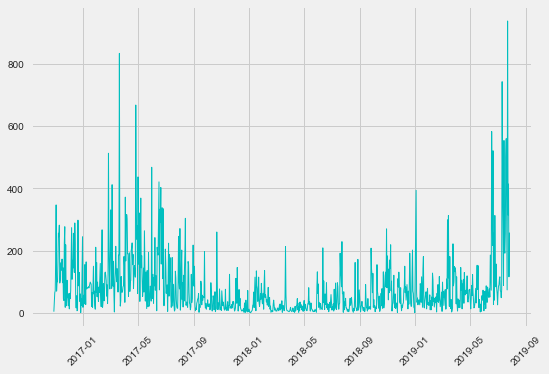

In [27]:
plt.plot(df_messages.groupby('date').size(), 'c-', linewidth= 1)
plt.xticks(rotation= '45')
plt.show()

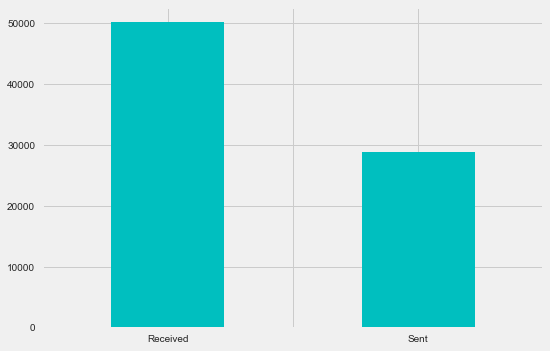

In [28]:
is_sent = pd.DataFrame(
    df_messages.groupby('is_sent').size()).transpose().rename(columns={0:'received', 1:'sent'})
plt.bar(left=[1,3], height=is_sent.iloc[0], width=0.9, color='c')
plt.xticks(range(5), ('', 'Received', '', 'Sent'))
plt.show()

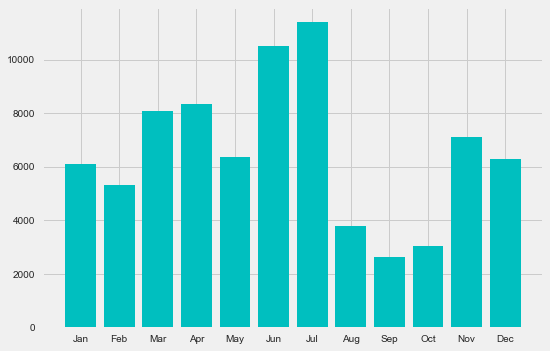

In [29]:
months = df_messages.groupby('month').size()
plt.bar(left=range(12), height=months, color='c')
plt.xticks(range(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.show()

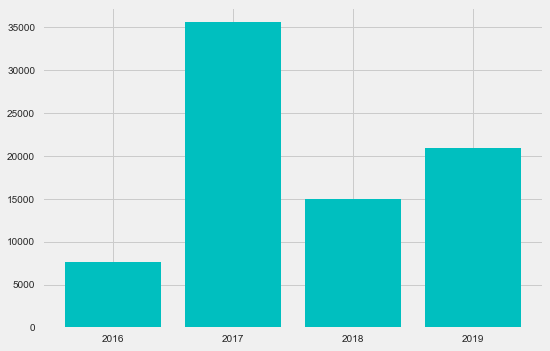

In [30]:
years = df_messages.groupby('year').size()
plt.bar(left=range(4), height=years, color='c')
plt.xticks(range(4), ('2016', '2017', '2018', '2019'))
plt.show()

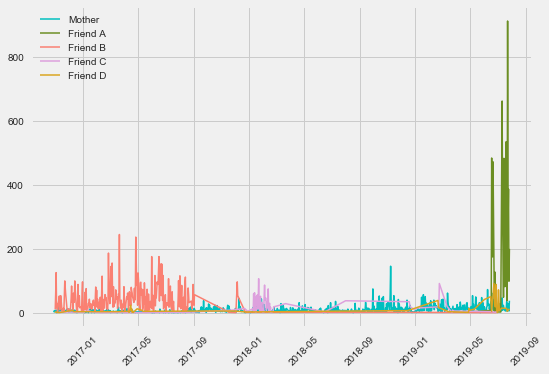

In [31]:
def phone_number_plot(number):
    dates = df_messages[['phone_number']]
    dates['date'] = pd.to_datetime(df_messages['timestamp']).dt.date
    dates_by_phone = dates.groupby(['phone_number', 'date']).size().reset_index().rename(columns={0:'total_messages'})
    temp = dates_by_phone[dates_by_phone['phone_number']== number][['date', 'total_messages']]
    return temp

mother = phone_number_plot('+')
friend_a = phone_number_plot('+')
friend_b = phone_number_plot('+')
friend_c = phone_number_plot('+')
friend_d = phone_number_plot('+')

plt.gca().set_color_cycle(['c', 'olivedrab', 'salmon', 'plum', 'goldenrod'])
plt.plot(mother['date'], mother['total_messages'], linewidth=1.5)
plt.plot(friend_a['date'], friend_a['total_messages'], linewidth=1.5)
plt.plot(friend_b['date'], friend_b['total_messages'], linewidth=1.5)
plt.plot(friend_c['date'], friend_c['total_messages'], linewidth=1.5)
plt.plot(friend_d['date'], friend_d['total_messages'], linewidth=1.5)

plt.legend(['Mother', 'Friend A', 'Friend B', 'Friend C', 'Friend D'])
plt.xticks(rotation=45)
plt.show()

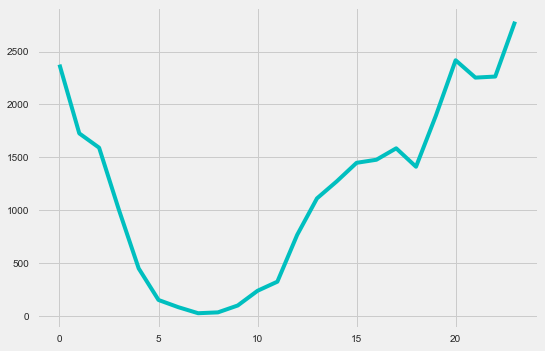

In [32]:
hours = pd.DataFrame(df_messages[df_messages['is_sent'] == 1]['timestamp'].apply(lambda x: x.hour))
hours = pd.DataFrame(hours.groupby('timestamp').size()).reset_index().rename(columns={0:'count'})
plt.plot(hours['count'], color='c')
plt.show()

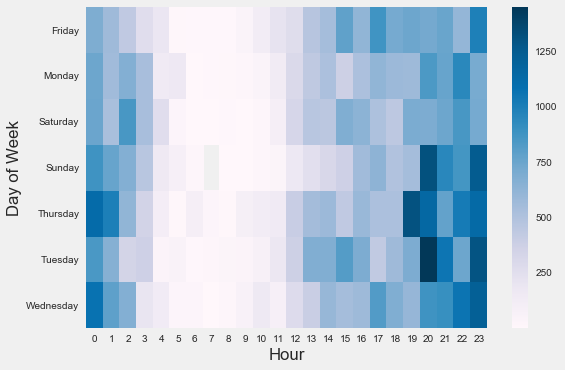

In [33]:
df_messages['hour'] = df_messages['timestamp'].apply(lambda x: x.hour)
df_messages['day_of_week'] = df_messages['timestamp'].apply(lambda x: x.day_name())
hours_day = df_messages[['hour', 'day_of_week']]
hours_day['count'] = np.ones(len(hours_day))
piv = pd.pivot_table(hours_day, values='count', index='hour', columns='day_of_week', aggfunc=np.sum)
piv = piv.transpose()

sns.heatmap(piv, cmap="PuBu")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.yticks(rotation=0)
plt.show()

In [34]:
def get_emojis(string):
    try:
        emojis = [emo for emo in string if emo in emoji.UNICODE_EMOJI]
    except TypeError:
        return 0
    if len(emojis) == 0:
        return 0
    else:
        return emojis

In [60]:
# Emojis I've Sent
emojis = df_messages[df_messages['is_sent'] == 1]['text'].apply(get_emojis)
emojis = list(chain.from_iterable(np.array(emojis[emojis != 0])))
df_emojis_sent = pd.DataFrame(emojis).rename(columns={0:'emojis'})
df_emojis_sent = pd.DataFrame(df_emojis_sent.groupby('emojis').size()).reset_index().rename(columns={0:'count'})
df_emojis_sent = df_emojis_sent.sort_values('count', ascending=False).reset_index(drop=True).iloc[:9]


styled_emojis_sent = df_emojis_sent.style.background_gradient(cmap="PuBu")
styled_emojis_sent

,emojis,count
0,😂,102
1,😤,88
2,👀,78
3,💀,70
4,💦,63
5,😉,55
6,🅱,47
7,😎,40
8,😩,39


In [64]:
# Emojis I've Received
emojis = df_messages[df_messages['is_sent'] == 0]['text'].apply(get_emojis)
emojis = list(chain.from_iterable(np.array(emojis[emojis != 0])))
df_emojis_rec = pd.DataFrame(emojis).rename(columns={0:'emojis'})
df_emojis_rec = pd.DataFrame(df_emojis_rec.groupby('emojis').size()).reset_index().rename(columns={0:'count'})
df_emojis_rec = df_emojis_rec.sort_values('count', ascending=False).reset_index(drop=True).iloc[:9]

styled_emojis_rec = df_emojis_rec.style.background_gradient(cmap="PuBu")
styled_emojis_rec

,emojis,count
0,😂,1689
1,😘,213
2,🤔,199
3,😭,174
4,😍,170
5,👀,126
6,🅱,105
7,💀,100
8,😎,99


In [68]:
def get_texts(number, top):
    temp = df_messages[df_messages['phone_number'] == number]
    emojis = temp['text'].apply(get_emojis)
    emojis = list(chain.from_iterable(np.array(emojis[emojis != 0])))
    df_emojis = pd.DataFrame(emojis).rename(columns={0:'emojis'})
    df_emojis = pd.DataFrame(df_emojis.groupby('emojis').size()).reset_index().rename(columns={0:'count'})
    return df_emojis.sort_values('count', ascending=False).reset_index(drop=True).iloc[:top]

In [70]:
# Mother
emojis_mother = get_texts('+', 3)
emojis_mother.style.background_gradient(cmap="PuBu")

,emojis,count
0,😘,176
1,😍,102
2,🙏,44


In [71]:
# Friend A
friend_a_emojis = get_texts('+', 3)
friend_a_emojis.style.background_gradient(cmap="PuBu")

,emojis,count
0,😂,134
1,😭,9
2,😩,6


In [72]:
#Friend B
friend_b_emojis = get_texts('+', 3)
friend_b_emojis.style.background_gradient(cmap="PuBu")

,emojis,count
0,😂,1012
1,😭,59
2,💀,58


In [73]:
# Friend C
friend_c_emojis = get_texts('+', 3)
friend_c_emojis.style.background_gradient(cmap="PuBu")

,emojis,count
0,😂,15
1,😭,7
2,😱,5


In [74]:
# Friend D
friend_d_emojis = get_texts('+', 3)
friend_d_emojis.style.background_gradient(cmap="PuBu")

,emojis,count
0,😂,39
1,😤,7
2,😭,5


In [78]:
stop = set(nltk.corpus.stopwords.words('english'))
stop_spanish = set(nltk.corpus.stopwords.words('spanish'))
stop.add('￼')

all_texts = list(df_messages.dropna(subset=['text'])['text'])
all_texts_string = ' '.join(all_texts)
all_texts_string = all_texts_string.translate(str.maketrans('', '', string.punctuation)).lower()
all_texts = all_texts_string.split(" ")
cleaned = []
for word in all_texts:
    if word not in stop and word not in stop_spanish:
        cleaned.append(word)
cleaned = " ".join(cleaned)

frequency = {}
    
tokens = nltk.tokenize.word_tokenize(cleaned)
words = pd.DataFrame(list(FreqDist(tokens).items())).rename(columns={0:'Word', 1:'Count'})
words[words['Count'] > 1000].sort_values('Count', ascending=False).reset_index(drop=True).iloc[:20].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,’,im,like,i,s,amo,get,t,dont,know,one,oh,m,si,got,good,amamos,go,ok,buenas
Count,6429,2566,2322,2016,1794,1731,1677,1595,1518,1510,1351,1339,1304,1246,1225,1206,1137,1134,1121,1082
